## II. Bakery Dataset

In [46]:
import os
import sys
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = ""

sys.path.append("../")
print(os.getcwd())

from choice_learn.basket_models import AleaCarta

/Users/michael.teboul/Documents/choice-learn-1/notebooks


In [47]:
from choice_learn.basket_models.data.preprocessing import load_bakery


data = load_bakery()
print(data)
print(f"\nThe TripDataset 'data' contains {data.n_items} distinct items that appear in {data.n_samples} transactions carried out at {data.n_stores} point(s) of sale with {data.n_assortments} different assortments.")

Files : ['uchoice-Bakery', 'uchoice-Bakery/uchoice-Bakery.txt', 'uchoice-Bakery/uchoice-Bakery-5-25.txt', 'uchoice-Bakery/README.txt']
TripDataset with 75000 trips

The TripDataset 'data' contains 50 distinct items that appear in 266209 transactions carried out at 1 point(s) of sale with 1 different assortments.


In [48]:
latent_sizes = {"preferences": 6, "price": 3, "season": 3}
n_negative_samples = 42
optimizer = "lfbgs"
lr = 1e-2
epochs = 20
# epochs = 1000
batch_size = 32



In [49]:
model = AleaCarta(
    # item_intercept=True,
    item_intercept=False,
    price_effects=False,
    seasonal_effects=False,
    latent_sizes=latent_sizes,
    n_negative_samples=n_negative_samples,
    optimizer=optimizer,
    lr=lr,
    epochs=epochs,
    batch_size=batch_size,
)

model.instantiate(n_items=data.n_items, n_stores=data.n_stores)

In [50]:
history = model.fit(trip_dataset=data[:1000], verbose=1, val_dataset=data[8000:9000])


Epoch 19 Train Loss 0.1000: 100%|██████████| 20/20 [02:51<00:00,  8.59s/it]


In [51]:
model.evaluate(trip_dataset=data[:1000])

3.2237226440082405

/var/folders/4n/g7n4s25944s77p645cqllzgh0000gp/T/ipykernel_43780/4062289676.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


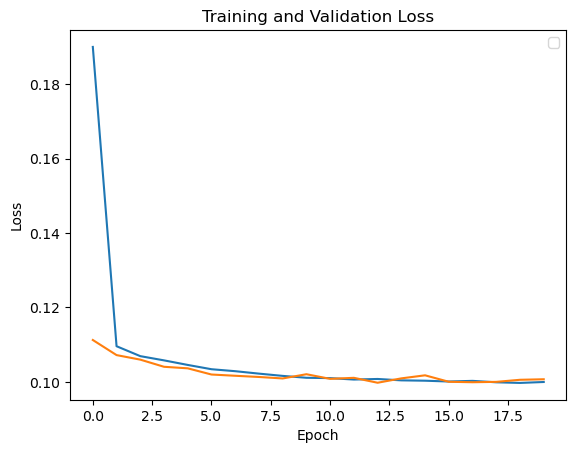

In [52]:
plt.plot(history["train_loss"])
plt.plot(history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")



plt.show()

In [53]:
import numpy as np

n_item = 50

n_comparaison = 50


item_batch = np.array(np.concatenate([[i]*n_comparaison for i in range(n_comparaison)]))
print('item_batch', item_batch)
basket_batch = np.concatenate([(np.arange(n_comparaison).reshape(-1, 1)) for i in range(n_comparaison)])

#basket_batch = np.array(np.concatenate([(np.arange(51)) for i in range(51)]))
print('basket_batch', basket_batch)
batch_size = n_comparaison**2

print('batch_size', batch_size)

available_item_batch =  np.array([[1]*n_item]*batch_size) 
price_batch = np.array([[1.0]*batch_size])

store_batch = np.array([0]*batch_size)
week_batch = np.array([0]*batch_size)



item_batch [ 0  0  0 ... 49 49 49]
basket_batch [[ 0]
 [ 1]
 [ 2]
 ...
 [47]
 [48]
 [49]]
batch_size 2500


In [54]:
compute_batch_utility = model.compute_batch_utility(item_batch=item_batch, basket_batch=basket_batch, price_batch=price_batch, available_item_batch=available_item_batch, store_batch=store_batch, week_batch=week_batch)
compute_batch_utility


<tf.Tensor: shape=(2500,), dtype=float32, numpy=
array([-2.0186305, -3.5635862, -2.1498847, ..., -4.9970164, -4.9805665,
       -4.979463 ], dtype=float32)>

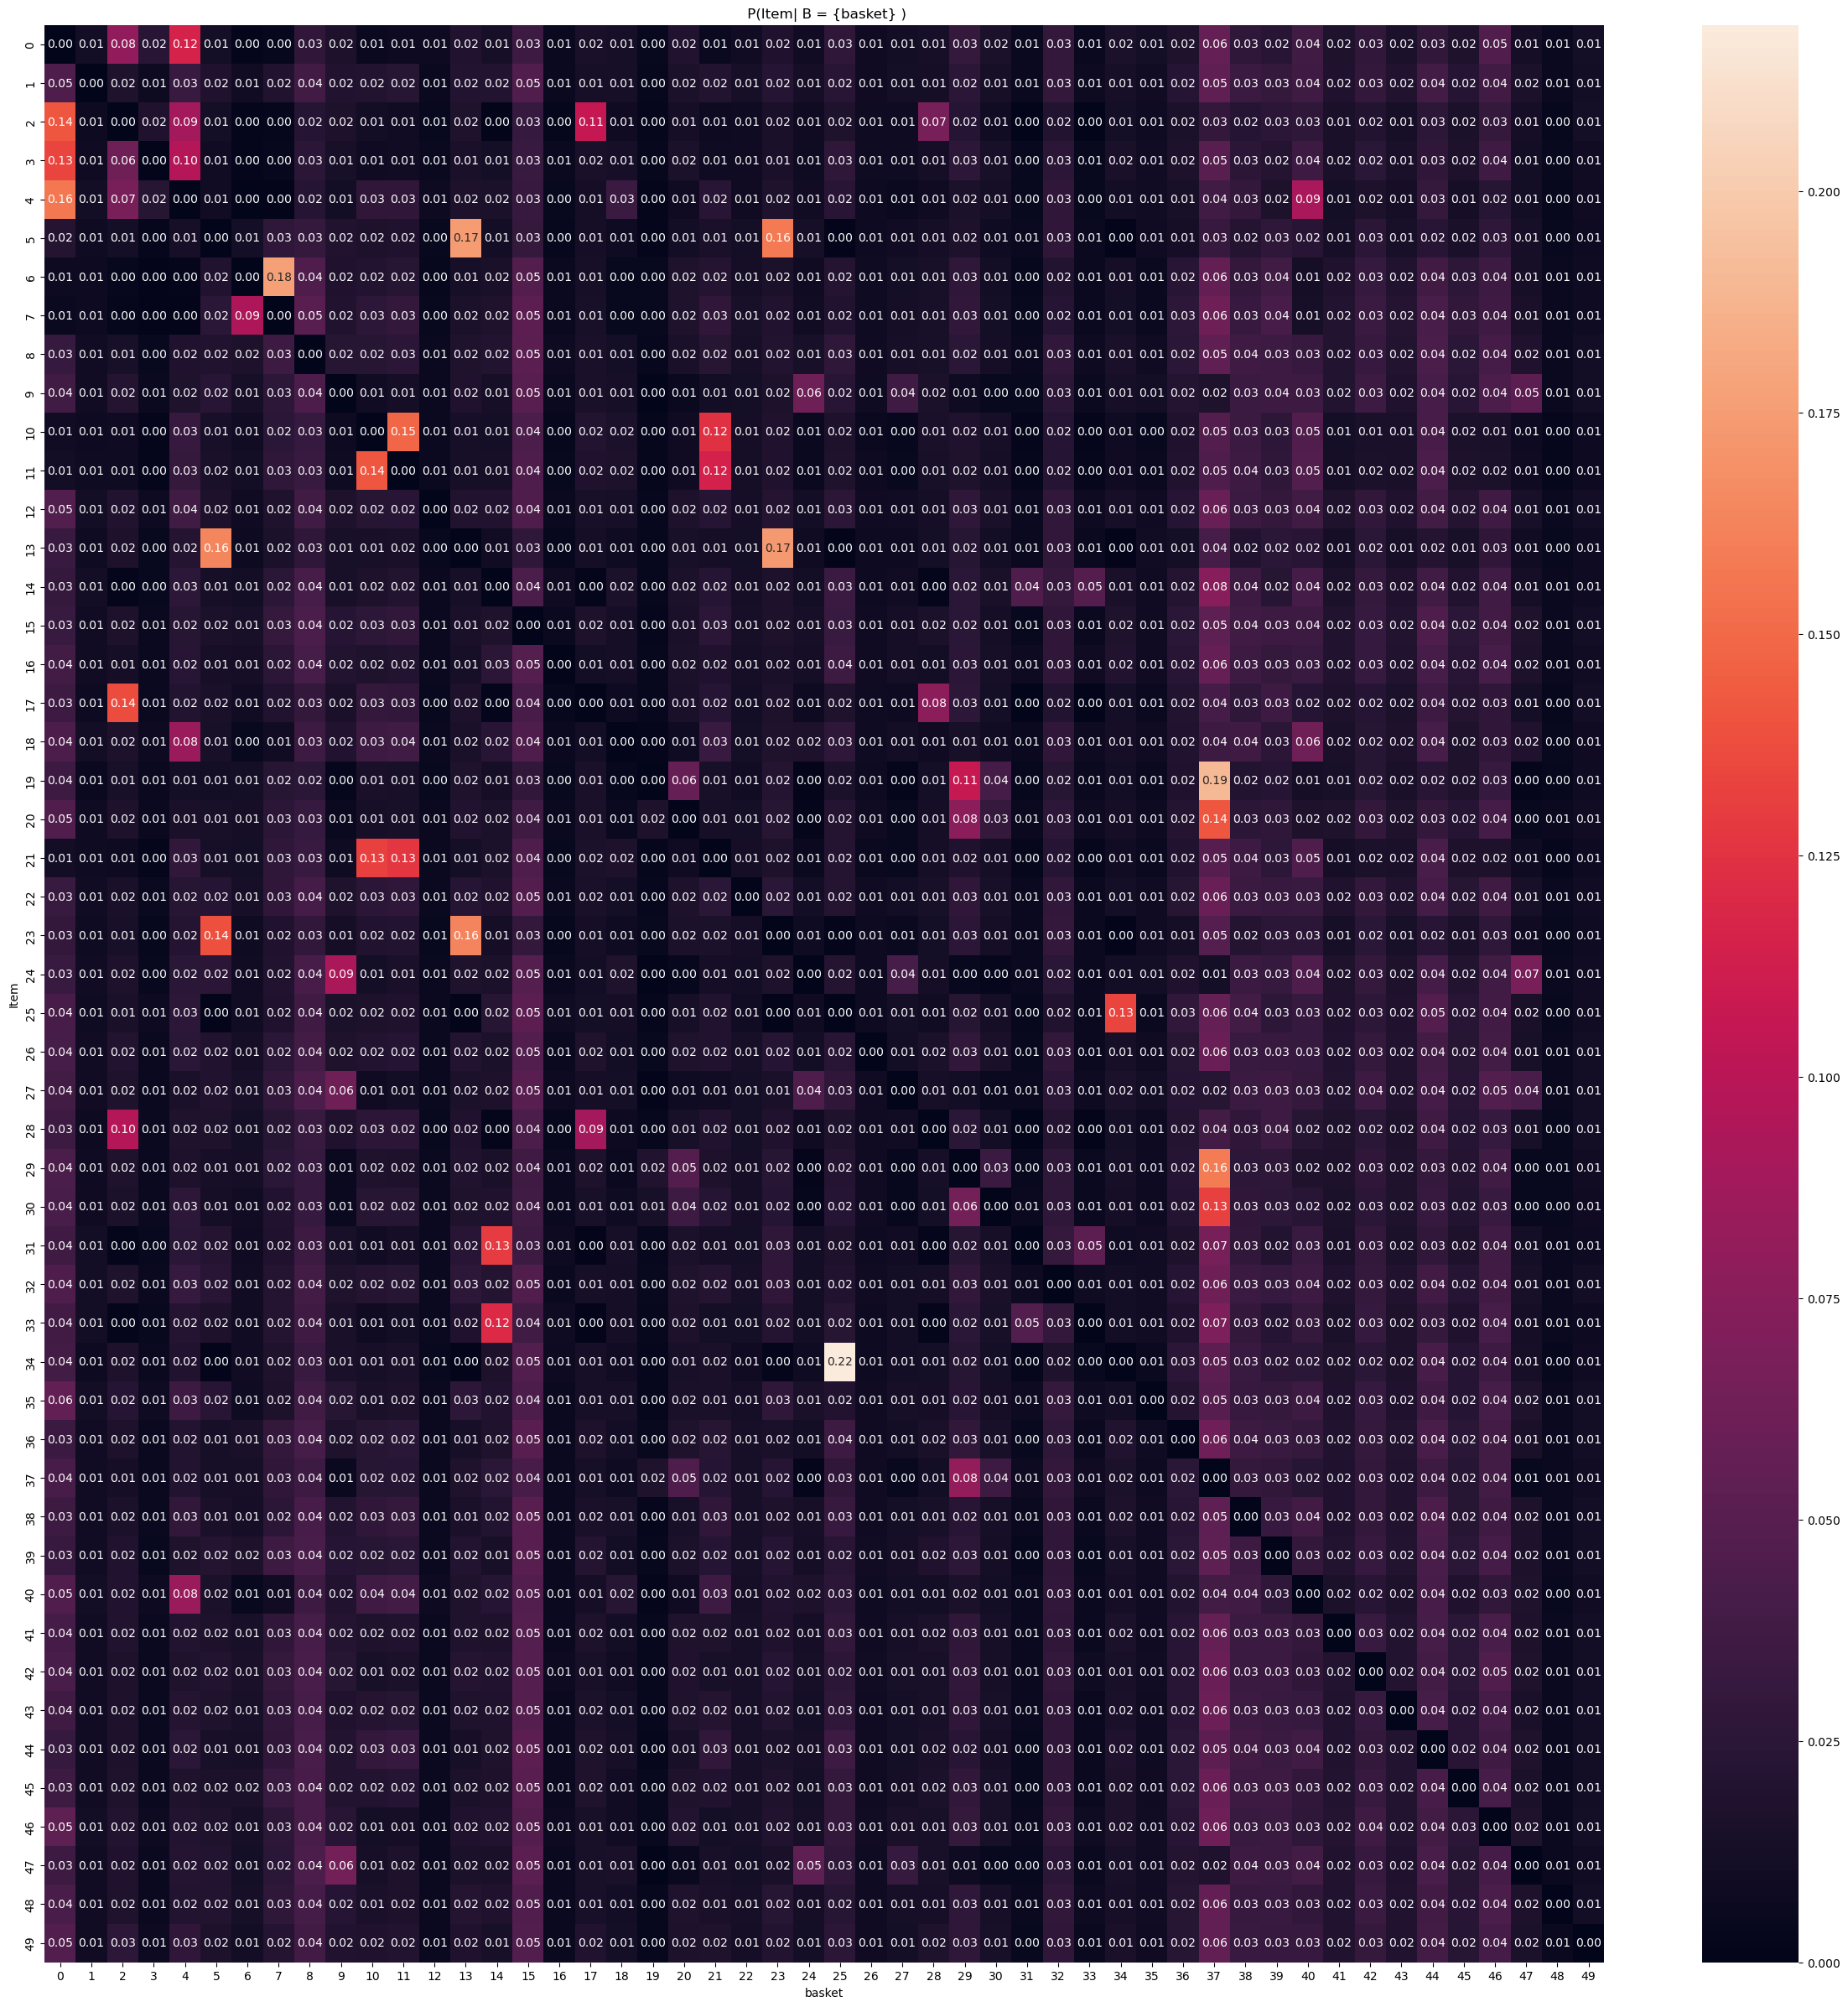

In [55]:
import seaborn as sns
import math
matrix = np.zeros(shape = (n_comparaison,n_comparaison))

for i in range(n_comparaison):
    for j in range(n_comparaison):
        if i == j:
            matrix[i,j] = - math.inf
        else :
            matrix[i,j] = compute_batch_utility[i + j*n_comparaison]

for i in range(n_comparaison):
    sum = np.sum(np.exp(matrix[i,:]))
    for j in range(n_comparaison):
        matrix[i,j] = np.exp(matrix[i,j])/sum


plt.figure(figsize=(30, 30))
sns.heatmap(matrix,
            annot=True,     
            fmt='.2f')
            #   ,cmap='viridis'   )   

plt.title(' P(Item| B = {basket} )') 
plt.ylabel('Item')   
plt.xlabel('basket')   
plt.show() 